<a href="https://colab.research.google.com/github/finedominos/synthetised-speech-dataset/blob/master/Dataset_Creation_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of a relevant subset of sentences from the LibriSpeech corpus of books
#### *This subset will then be inputted to some TTS tools to populate the target dataset of synthesized speech*

Starting from the "clean" subset of LibriSpeech corpus of audiobooks, we extract and analyse the textual sentences and the corresponding audio files in order to finally draw a subset of sentences that will then be used as an input to the chosen TTS tools, with the goal of creating a synthesized speech dataset.

The principal output of this notebook is a JSON file containing the aforementioned subset of sentences that will be used in both other notebooks of this project: *Dataset Evaluation - Main* and *Reccurent error word and PER*

More information on LibriSpeech can be found in this article: 
https://ieeexplore.ieee.org/document/7178964?source=post_page---------------------------

# Importing libraries and Librispeech dataset

In [1]:
import numpy as np
from pathlib import Path
import random
import shutil
import IPython
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import requests
import json
import pandas as pd

In [2]:
# variable to choose if we import the test-clean set as well
import_test_clean = True

In [3]:
import tarfile
if not os.path.isdir("LibriSpeech"):
  # Getting the .tar.gz file from LibriSpeech ("dev-clean" set from https://www.openslr.org/12)
  !wget https://www.openslr.org/resources/12/dev-clean.tar.gz
  tar = tarfile.open("dev-clean.tar.gz")
  tar.extractall()
  tar.close()
  !rm dev-clean.tar.gz

  if import_test_clean: # getting the test subset
    !wget https://www.openslr.org/resources/12/test-clean.tar.gz
    tar_test = tarfile.open("test-clean.tar.gz")
    tar_test.extractall()
    tar_test.close()
    !rm test-clean.tar.gz

else:
  print("LibriSpeech already downloaded :)")

--2021-07-21 09:55:04--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  32.3MB/s    in 11s     

2021-07-21 09:55:15 (29.9 MB/s) - ‘dev-clean.tar.gz’ saved [337926286/337926286]

--2021-07-21 09:55:18--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  32.8MB/s    in 11s     

2021-07-21 09:55:29 (30.4 MB/s) - ‘test-clean.tar.gz’ saved [346

# Functions

## Chapters information extraction

In [4]:
def get_chapters_info():
  """
  Reading the file CHAPTERS.TXT, in which the data is organized as:
  ID|READER|MINUTES|SUBSET|PROJ.|BOOK ID|CH. TITLE|PROJECT TITLE (Book title)
  Returns:
    chapters_info: List with the information about chapters coming from the chosen subset "dev-clean"
  """


  chapters_file = open("LibriSpeech/CHAPTERS.TXT") # Open the text file containing info about all chapters
  chapters_info_all = chapters_file.readlines()
  chapters_info_all = chapters_info_all[14:]        # Remove the first several lines with just text (kinda readme)

  # Only extracting the chapters info from the dev-clean subset
  chapters_info = [] 
  for item in chapters_info_all:
    subset = item.split("| ")[3]
    if "dev-clean" in subset: # Not using equivallence (==) because of spaces in the string
      chapters_info.append(item)

  if import_test_clean:
    for item in chapters_info_all:
      subset = item.split("| ")[3]
      if "test-clean" in subset: # Not using equivallence (==) because of spaces in the string
        chapters_info.append(item)


  #print("Number of chapters in the whole LibriSpeech dataset:", len(chapters_info_all))
  print("Number of chapters in the chosen subset of chapters 'dev-clean' and 'test-clean':", len(chapters_info))

  return chapters_info

## Extracting the lines of text from the chapters

In [7]:
# Extract the lines from the text files of chapters

def extract_lines(chaptersPaths, chaptersTable, debugModeOn=False):
  """
  Extracting lines from chapters into the list content_lines (array with 2 columns):
  The first column is with indexes (speaker-chapter-line, example "1919-142785-0063")
  The second column is with strings corresponding to lines (example "ILLUSTRATION SAGE")
  """
  
  content_lines = []
  chaptersIDs = list(map(int, chaptersTable[:,0])) # Extract only the list of chapter IDs
  # print(chaptersIDs)

  for i, file in enumerate(chaptersPaths):
    chapter_id = int(file.split("/")[3])

    # If the current chapter belongs to the list of considered chapters
    if (chapter_id in chaptersIDs):
      f = open(file, "r")                 # Open each file to read it
      content = f.readlines()             # Read all lines into a list
      for line in content:                # Iterate through each line in a list. example of line: "1919-142785-0063 ILLUSTRATION SAGE\n"
        string = line.split('\n')[-2]     # Remove the "\n" from lines
        string = string.split(' ', 1)     # Split the string after the first space, keep both parts. example of result: ['1919-142785-0063', 'ILLUSTRATION SAGE']
        content_lines.append(string)      # Add the extracted strings to the list of lines


  if debugModeOn:
    print("Number of lines after filtering:", len(content_lines))

  return np.asarray(content_lines)
  

## Books publication year extraction

In [5]:
def get_publication_years(chaptersInfo, debugModeOn = False):
  """
  Searching for the books' published year.
  Going through the information about chapters from "dev-clean", extracting lists.
  Parameters:
    chaptersInfo: Extracted information about chapters
  Returns:
    chapters_table: The list of chapters IDs from the list chapters_info, the corresponding books' published years, and the book titles
    books_table: The list of book titles and corresponding published years (only different books)
  """

  chapters_table = []
  books_table = []
  
  prev_book_id = None

  url = r"https://www.googleapis.com/books/v1/volumes" # TODO: find what is this volumes in the url?

  for i in range(len(chaptersInfo)):
    chapter_id = chaptersInfo[i].split("| ")[0]
    if debugModeOn:
      print("Line no.", i)
      print("Chapter ID ", chapter_id)
    book_id = chaptersInfo[i].split("| ")[5]
    book_title = chaptersInfo[i].split("| ")[7]

    # Do the query only when a new book is examined
    # (Since several chapters refer to the same book)
    
    if (prev_book_id != book_id):
      year_found = False    # For keeping track if the info about the published year is accessible
      #print("New query starting for book ID: ", book_id)

      # Building the query
      book_query = "intitle:" + book_title
      params = {"q": book_query}
      response = requests.get(url, params = params)
      response_dict = response.json()
      if "items" in response_dict:
        response_all_results = response_dict["items"]
  # For eventual debugging 
  #    else:
  #      print("No key named items in the dictionary")
      
      # Exploring all results found for the chosen book
      
      result_year_earliest = 2021  # The earliest found year: initialized to today
      
      for result in response_all_results:
        if "volumeInfo" in result:
          result_info = result["volumeInfo"]
          if "publishedDate" in result_info:   # If there is information about the published date
            result_year_str = result_info["publishedDate"]
            if (result_year_str[:4].isdigit()):  # If the published date string can be converted to a digit
              result_year = int(result_year_str[:4])
              year_found = True

              # If the currently examined book is earlier than the earliest found so far
              if (result_year < result_year_earliest):
                result_year_earliest = result_year
      
      if year_found == True: # If the published year successfully found, add it to the list of years
        books_table.append([book_title, int(result_year_earliest)])
                      

  # For eventual debugging      
  #          else:
  #            print("The found published date is not a digit")    
  #        else:
  #          print("No key named publishedDate in the dictionary")        
  #      else:
  #        print("No key named volumeInfo in the dictionary")"""
                
              
    if year_found == True: # If the published year successfully found, add it to the list of years
      chapters_table.append([chapter_id, int(result_year_earliest), book_title])
      if debugModeOn:
        print("Earliest found published year of the book '", book_title,"': ", result_year_earliest, "\n")
    else:
      print("No info found about the published year of the book '", book_title[:-1], "\n")
      
    prev_book_id = book_id

  chapters_table = np.asarray(chapters_table)
  books_table = np.asarray(books_table)

  for ch in chapters_table:
    ch_title = (ch[2])[:-1]
    ch[2] = ch_title
    ch_id = int(ch[0])
    ch[0] = ch_id

  for b in books_table:
    b_title = (b[0])[:-1]
    b[0] = b_title
  
  if debugModeOn:
    print("Number of different books in the chosen subset of chapters:", len(books_table))
    print("\n")

  return chapters_table, books_table

## Filtering the dataset according to the published year data

In [6]:
def filter_by_publication_year(chaptersTable, yearMin=1800, debugModeOn=False):
  """
  The function filter_by_publication_year filters the dataset of chapters according to the published year data
  Parameters:
    chaptersTable (2D array) - the list of chapters information to be filtered (chapters ID, published year, book title)
    yearMin - the earliest published year to consider
    debugModeOn
  Returns:
    chaptersTableFilter
  """
  chaptersTableFilter = []

  for i in range(len(chaptersTable[:,0])):
    if (int(chaptersTable[i,1]) > yearMin):
      chaptersTableFilter.append(chaptersTable[i])
    elif debugModeOn:
      print("Deleted chapter with the ID no. ", chapters_table[i,0])
        
  print("\nNumber of chapters in the original subset:", len(chaptersTable))
  print("Number of chapters in the filtered subset:", len(chaptersTableFilter))
 
  chaptersTableFilter = np.asarray(chaptersTableFilter)
  
  return chaptersTableFilter

## Filtering sentences with non-standard words (according to NLTK)

In [8]:
import nltk
nltk.download('words')
nltk.download('wordnet')
# Basic vocabulary dictionary:
english_vocab = set(w.upper() for w in nltk.corpus.words.words())

# Lemmatizer:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# Adding all country names: (We estimate countries are common language)
!pip install pycountry
import pycountry
countries = []
for country in pycountry.countries:
  countries += (country.name.upper().split(" ")[:])
  countries.append('ENGLAND') # Because of uk it's not in...

# Other frequent common words still not in english_vocab
other_allowed_exceptions = ["OTHERS", "LONDON", "SYDNEY", "EUROPE", 'FAVOUR', 'FAVOURABLE', 'FAVOURITE'] # what about SAVOUR, VAPOUR,... would also be an issue for speech to text, so I'd say no... but, what about americans versions... *outliers*

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 10.1 MB 39.3 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=813b6251a59262b3fb88c326b0345a77306952282a6618c873613ed7a5b41475
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


### Dictionary of contractions

In [9]:
contractions_dict = { 
# "ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
# "can't've": "cannot have",
# "'cause": "because",
"could've": "could have",
"couldn't": "could not",
# "couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
# "hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
# "he'd've": "he would have",
"he'll": "he shall / he will",
# "he'll've": "he shall have / he will have",
"he's": "he has / he is",
# "how'd": "how did",
# "how'd'y": "how do you",
# "how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
# "I'd've": "I would have",
"I'll": "I shall / I will",
# "I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
# "it'd've": "it would have",
"it'll": "it shall / it will",
# "it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
# "ma'am": "madam",
# "mayn't": "may not",
# "might've": "might have",
# "mightn't": "might not",
# "mightn't've": "might not have",
# "must've": "must have",
"mustn't": "must not",
# "mustn't've": "must not have",
# "needn't": "need not",
# "needn't've": "need not have",
"o'clock": "of the clock",
# "oughtn't": "ought not",
# "oughtn't've": "ought not have",
# "shan't": "shall not",
# "sha'n't": "shall not",
# "shan't've": "shall not have",
"she'd": "she had / she would",
# "she'd've": "she would have",
"she'll": "she shall / she will",
# "she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
# "shouldn't've": "should not have",
# "so've": "so have",
# "so's": "so as / so is",
"that'd": "that would / that had",
# "that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
# "there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
# "they'd've": "they would have",
"they'll": "they shall / they will",
# "they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
# "to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
# "we'd've": "we would have",
"we'll": "we will",
# "we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
# "what'll've": "what shall have / what will have",
# "what're": "what are",
# "what's": "what has / what is",
# "what've": "what have",
# "when's": "when has / when is",
# "when've": "when have",
# "where'd": "where did",
# "where's": "where has / where is",
# "where've": "where have",
# "who'll": "who shall / who will",
# "who'll've": "who shall have / who will have",
# "who's": "who has / who is",
# "who've": "who have",
# "why's": "why has / why is",
# "why've": "why have",
# "will've": "will have",
"won't": "will not",
# "won't've": "will not have",
# "would've": "would have",
"wouldn't": "would not",
# "wouldn't've": "would not have",
"y'all": "you all",
# "y'all'd": "you all would",
# "y'all'd've": "you all would have",
# "y'all're": "you all are",
# "y'all've": "you all have",
"you'd": "you had / you would",
# "you'd've": "you would have",
"you'll": "you shall / you will",
# "you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_upper_list = [string.upper() for string in contractions_dict.keys()]

### Filtering function

In [10]:
KEEP_CONTRACTIONS = True

def filter_non_existing_words(sentences_list, debugModeOn=False):
  """ Filters the list of sentences discard the ones with unexisting words 
  in NLTK's dictionary

  :param sentences_list: list of sentences [sentence_id, uppercase_sentence]
  :returns: filtered list of sentences, same format
  """
  number_true = 0
  number_false = 0
  number_countries = 0
  number_contractions = 0
  number_exceptions = 0
  word_count = 0    # Just checkin'
  list_false = []
  filtered_dataset = []
  for i,sentence in enumerate(sentences_list[:,1]):
    flag = True
    for word in sentence.split(" "):
      word_count += 1
      if word in english_vocab:
        number_true += 1
      elif lemmatizer.lemmatize(word.lower(), 'n').upper() in english_vocab:   # Plural is also not included in english_vocab, so lemmatizing to singular
        number_true += 1 
      elif lemmatizer.lemmatize(word.lower(), 'v').upper() in english_vocab:  # Conjugated verbs as well / past participal
        number_true += 1 
      elif lemmatizer.lemmatize(word.lower(), 'a').upper() in english_vocab:  # Comparative and Superlative
        number_true += 1 
      # elif lemmatizer.lemmatize(word.lower(), 's').upper() in english_vocab:  # Superlative
      #   print("sattelite: ", word)
      #   number_true += 1 
      # elif lemmatizer.lemmatize(word.lower(), 'r').upper() in english_vocab:  # Adverbs
      #   print("adverbs: ", word)
      #   number_true += 1 
      elif word in countries:  # Comparative and Superlative
        number_true += 1 
        number_countries += 1
      elif word in contractions_upper_list and KEEP_CONTRACTIONS:  # I'm, won't, shouldn't, etc...
        number_true += 1 
        number_contractions += 1
      elif word in other_allowed_exceptions and KEEP_CONTRACTIONS:  # I'm, won't, shouldn't, etc...
        number_true += 1 
        number_exceptions += 1
      elif word[-2:]=="'S": # Possessive
        if word[:-2] in english_vocab:
          number_true += 1
        else:
          flag = False
          number_false += 1
          list_false.append((word[:-2], sentence))
      else:
        flag = False
        number_false += 1
        list_false.append((word, sentence))
  
    if flag:
      filtered_dataset.append(sentences_list[i][:])

  if debugModeOn:
    print("Total number of words words: ",word_count)
    print("Number of existing words: ",number_true)
    print("Number of unexisting words: ",number_false)
    print("Number of countries: ",number_countries)
    print("Number of contractions: ",number_contractions)
    print("Number of other exceptions: ",number_exceptions)

  return np.asarray(filtered_dataset)


## Filtering sentences by number of words (eliminating too short/long sentences)

In [11]:
# Basic words counter function

def words_counter(string):
  word_list = []
  word_list = string.split(" ")
  n_word = len(word_list)
  return n_word

In [12]:
# Filtering the sentences according to their length

def filtering_word_count(contentLines, bounds=(0.1,0.7), debugModeOn=False):
  lengths=[] # array with lengths of each sentence in the dataset
  for s in contentLines:
    sentence_len=words_counter(s[1]) # nb: s[1] is the sentence itself, while s[0] is the sentence id
    lengths.append(sentence_len)
  lengths=np.expand_dims(np.asarray(lengths),1)

  mean_len=np.mean(lengths)
  max_len=np.max(lengths)
  min_len=np.min(lengths)
  arg_min=np.argmin(lengths)
  arg_max=np.argmax(lengths)

  if debugModeOn:
    print("The mean is %f" %mean_len)
    print("The max is %d at indice %d" %(max_len, arg_max))
    print("The sentence is")
    print(contentLines[arg_max][1])
    print("The min is %d at indice %d" %(min_len, arg_min))
    print("The sentence is")
    print(contentLines[arg_min][1])

  #histogram of lengths of sentences in the dataset

  plt.figure(figsize = (10,6))
  bins=np.arange(min_len,max_len)
  a=plt.hist(lengths, bins=bins)
  plt.title("Lenghts of lines in the LibriSpeech corpus")
  plt.xlabel("Number of words in a line")
  plt.ylabel("Number of lines")
  plt.xlim(0)
  plt.show()

  if debugModeOn:
    print("Sentences with same lenghts (from %d to %d)" %(min_len,max_len))
    print(a[0])

  # Filtering (eliminating too long/short sentences)

  arg_sort=np.argsort(lengths,axis=0)
  sorted_length=np.reshape(lengths[arg_sort],(lengths[arg_sort].shape[0],1)) #sort the lengths fom smaller to longer
  sorted_dataset = np.reshape(contentLines[arg_sort],(contentLines[arg_sort].shape[0],2)) #sort the dataset by sentences length
  min_bound=int(lengths.shape[0]*bounds[0]) # minimum length sentence index
  max_bound=int(lengths.shape[0]*bounds[1]) # maximum length sentence index

  filtered_dataset=sorted_dataset[min_bound:max_bound,:] #reduce the dataset
  filtered_dataset_lengths=sorted_length[min_bound:max_bound,:]

  # Histogram of lengths after filtering
  
  min2=np.min(filtered_dataset_lengths)
  max2=np.max(filtered_dataset_lengths)

  bins2=np.arange(min2,max2)
  b=plt.hist(filtered_dataset_lengths, bins=bins2)  # arguments are passed to np.histogram
  plt.title("Histogram of new lengths")
  plt.show()

  print("Kept sentences with lengths between %d and %d"%(min2, max2))

  if debugModeOn:
    print("Sentences with same lenghts (from %d to %d)" %(min2,max2))
    print(b[0])

  return filtered_dataset


##WER based filter (for the branch 2 of the filtering)

In [13]:
# Installing the STT libraries

!sudo apt-get install -qq python python-dev python-pip build-essential swig libpulse-dev

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libpulse-mainloop-glib0:amd64.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../00-libpulse-mainloop-glib0_1%3a11.1-1ubuntu7.11_amd64.deb ...
Unpacking libpulse-mainloop-glib0:amd64 (1:11.1-1ubuntu7.11) ...
Selecting previously unselected package libpulse-dev:amd64.
Preparing to unpack .../01-libpulse-dev_1%3a11.1-1ubuntu7.11_amd64.deb ...
Unpacking libpulse-dev:amd64 (1:11.1-1ubuntu7.11) ...
Selecting previously unselected package libpython-all-dev:amd64.
P

In [14]:
!pip install SpeechRecognition pydub
# !pip install pocketsphinx
!pip install jiwer

import speech_recognition as sr
# import pocketsphinx
import jiwer #library for wer
import json

     |████████████████████████████████| 32.8 MB 36 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149859 sha256=2318de35d743fa5c441e6182a102fed5035df16bb878c244f3135170e52cc027
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [15]:
# nb: WER = Word Error Rate

def filter_by_WER(list_of_audio_paths, dataset_sentences):
  """
  Filters the list of sentences according to the WER of the transcribed audio files.
  The transcription of audio files is done by a Google's Speech-To-Text tool.

  """
  lines_filtered=[]
  for i, audio_path in tq.tqdm(enumerate(list_of_audio_paths), total=len(list_of_audio_paths)):

    # Finding the original sentence from the sentence id
    sentence_id = (audio_path.split('/')[-1]).split(".")[0]
    original_found = False
    for j, sentence in enumerate(dataset_sentences):
      if sentence_id == dataset_sentences[j,0]:
        text_original = dataset_sentences[j,1]
        original_found = True
    if not original_found:
      raise Exception("original sentence not found")
    
    # Reading the audio file
    recogniser = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
      # listen for the data (load audio to memory)
      audio_data = recogniser.record(source)

    # STT and WER
    try:
      # GOOGLE speech to text
      text_google = recogniser.recognize_google(audio_data).upper()
      # Compute Word Error Rate
      wer_google = jiwer.wer(text_original, text_google)
    except:
      print("error with sentence: ",sentence_id,"(actual sentence:",text_original,")")
      wer_google = 1
    if wer_google == 0:
      lines_filtered.append(dataset_sentences[i][:])

  return np.asarray(lines_filtered)

# Main

## Parameters

In [27]:
# Parameters

min_publication_year = 1850     # Earliest published date to consider for the books of the dataset
debug_mode = False             # If True, functions will print outputs and logs

## Extracting data

In [28]:
chapters_info = get_chapters_info()

Number of chapters in the chosen subset of chapters 'dev-clean' and 'test-clean': 184


In [29]:
chapters_table, books_table = get_publication_years(chapters_info, debug_mode)

In [30]:
# chapters_table is organized as: [chapter_id, book_year, book_title]
# books_table is organized as: [book_title, book_year]

print("chapter_table shape:",chapters_table.shape)
print("Example line of chapters_table: ",chapters_table[2])
print("Example line of books_table: ", books_table[2])

print("Number of different books: ", len(books_table))

chapter_table shape: (184, 3)
Example line of chapters_table:  ['8226' '1869' 'He Knew He Was Right']
Example line of books_table:  ['Hypatia' '1975']
Number of different books:  117


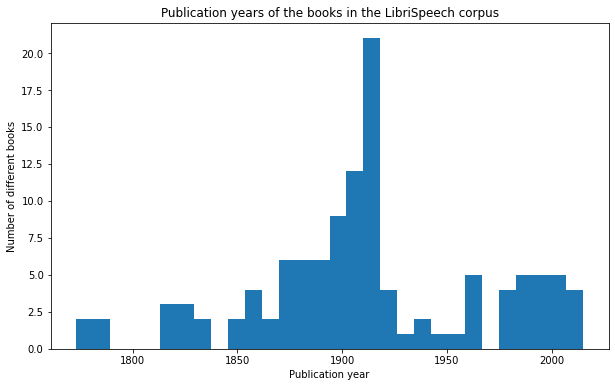

In [31]:
# Histogram

plt.figure(figsize = (10,6))
plt.hist(list(map(int, books_table[:,1])), bins = 30)
#plt.axvline(x=min_publication_year, color='k', linestyle='--') # Plotting the published year threshold
plt.title("Publication years of the books in the LibriSpeech corpus")
plt.xlabel("Publication year")
plt.ylabel("Number of different books")
plt.show()

In [32]:
# Getting the list of chapters (text files)
chapters_paths = [str(file) for file in Path().glob("LibriSpeech/dev-clean/*/*/*.trans.txt")]
if import_test_clean:
  chapters_paths_test = [str(file) for file in Path().glob("LibriSpeech/test-clean/*/*/*.trans.txt")]
  chapters_paths = chapters_paths + chapters_paths_test

print("Number of chapters:", len(chapters_paths))

Number of chapters: 184


## Filtering - Branch 1
####*applying filtering on sentences length, book year and uncommon words*

In [33]:
# Filtering by book published year
chapters_table_filtered = filter_by_publication_year(chapters_table, min_publication_year)
print("Example line of chapters_table_filtered: ", chapters_table_filtered[0])


Number of chapters in the original subset: 184
Number of chapters in the filtered subset: 165
Example line of chapters_table_filtered:  ['4943' '1886' 'For the Term of His Natural Life']


In [34]:
content_lines = extract_lines(chapters_paths, chapters_table_filtered, debugModeOn=True)
print("\nExample first column of the 1st element of content_lines:\n", content_lines[0,0])
print("Example second column of the 2nd element of content_lines:\n", content_lines[0,1])

Number of lines after filtering: 4809

Example first column of the 1st element of content_lines:
 3081-166546-0000
Example second column of the 2nd element of content_lines:
 WHEN WE TOOK OUR SEATS AT THE BREAKFAST TABLE IT WAS WITH THE FEELING OF BEING NO LONGER LOOKED UPON AS CONNECTED IN ANY WAY WITH THIS CASE


In [35]:
# Filtering by removing sentences with words that nltk doesn't know
content_lines_filtered = filter_non_existing_words(content_lines, debug_mode)
print("Number of lines after filtering non-existing words:", len(content_lines_filtered))


# If filtering non-existing words from the original dataset, it reduces from 2703 to 2151 lines
# If filtering from the dataset filtered by years, it reduces from 2367 to 1868 lines

Number of lines after filtering non-existing words: 3804


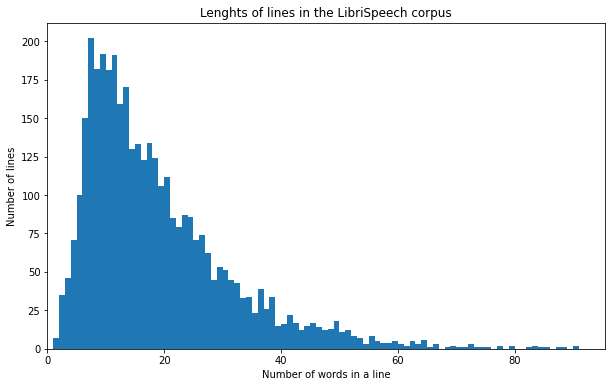

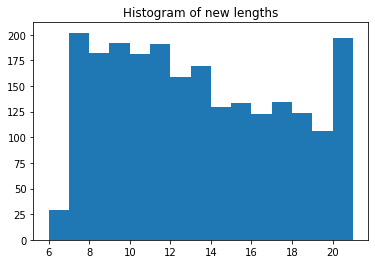

Kept sentences with lengths between 6 and 22
Number of lines after filtering by sentences length: 2282


In [36]:
# Filtering by sentences length

content_lines_filtered_final = filtering_word_count(content_lines_filtered, bounds=(0.1,0.7), debugModeOn=debug_mode)
print("Number of lines after filtering by sentences length:", len(content_lines_filtered_final))

In [37]:
print(content_lines_filtered_final.shape)
print(content_lines_filtered_final[1])

(2282, 2)
['6295-244435-0006' 'BUT THE NEGOTIATIONS WERE SOON COMPLETED']


## Filtering - Branch 2
####*applying a filter based on the WER between original sentences and the STT transcription of the original audio files available in the Librispeech database*

In [38]:
# WER: reading the audio files from LibriSpeech
audio_paths = [str(file) for file in Path().glob("LibriSpeech/*/*/*/*.flac")]

In [39]:
# WER filter

content_lines_all = extract_lines(chapters_paths, chapters_table)
content_lines_WER_zero = filter_by_WER(audio_paths, content_lines_all)
print(content_lines_WER_zero)
print(len(content_lines_WER_zero))

error with sentence:  121-123852-0001 (actual sentence: AY ME )
error with sentence:  5142-33396-0013 (actual sentence: HE IS BUT A BOY THE MEN SAID )
error with sentence:  5142-33396-0048 (actual sentence: BY THE HAMMER OF THOR SHOUTED GRIM HERE IS NO STINGY COWARD )
error with sentence:  5142-33396-0067 (actual sentence: BUT YOUNG SHARP TONGUE NOW THAT WE HAVE CAUGHT YOU WE WILL PUT YOU INTO A TRAP THAT YOU CANNOT GET OUT OF )
error with sentence:  5142-33396-0060 (actual sentence: TAKE HIM OUT THORKEL AND LET HIM TASTE YOUR SWORD )
error with sentence:  5142-33396-0027 (actual sentence: HE ACTS AS THOUGH HE HAD NOT EXPECTED US )
error with sentence:  5142-33396-0026 (actual sentence: MY MEN LAUGHED YES A STINGY HOST )
error with sentence:  5142-33396-0036 (actual sentence: SO I WILL GIVE OUT THIS LAW THAT MY MEN SHALL NEVER LEAVE YOU ALONE )
error with sentence:  5142-33396-0047 (actual sentence: MY MEN POUNDED THE TABLE WITH THEIR FISTS )
error with sentence:  5142-36377-0011 (actu

## Writing both filtered subsets in JSON

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
subset_3_filters = (content_lines_filtered_final[:,0]).tolist() # keeping only lines IDs (first column)
subset_wer_filter = (content_lines_WER_zero[:,0]).tolist()

#with open("dataset_3_filters.json", "w") as outfile:
    #json.dump(filtered_dataset, outfile, indent=4)  

with open('/content/subset_3_filters.json', 'w') as f:
    json.dump(subset_3_filters, f, indent=4)
with open('/content/subset_wer_filter.json', 'w') as f:
    json.dump(subset_wer_filter, f, indent=4)

## Opening the 2 subsets of sentences obtained by the 2 sets of filters 
####*+ generating the final subset of all eligible sententences by intersecting them*

In [42]:
with open("/content/subset_3_filters.json", "r") as jsonfile:
    data_filters = json.load(jsonfile)

with open("/content/subset_wer_filter.json", "r") as jsonfile:
   data_wer = json.load(jsonfile)


print("Number of lines filtered with 3 firsts filters: ", len(data_filters))
print("Number of lines filtered with the filter based on WER: ", len(data_wer))

print("\ndata_filters: ", data_filters)
#print("data_wer: ", data_wer)

Number of lines filtered with 3 firsts filters:  2282
Number of lines filtered with the filter based on WER:  1622

data_filters:  ['652-130737-0012', '6295-244435-0006', '672-122797-0019', '2803-154328-0021', '777-126732-0026', '3081-166546-0033', '672-122797-0059', '672-122797-0060', '121-127105-0016', '1995-1837-0008', '672-122797-0029', '4507-16021-0019', '672-122797-0031', '6313-66129-0032', '5536-43358-0000', '251-137823-0025', '7127-75946-0005', '174-84280-0014', '3536-8226-0009', '3081-166546-0002', '672-122797-0009', '6313-66129-0019', '6295-244435-0027', '5694-64025-0013', '3752-4944-0019', '672-122797-0005', '3752-4943-0017', '6829-68769-0042', '121-127105-0033', '2078-142845-0035', '8455-210777-0066', '6241-61943-0022', '3752-4944-0029', '5338-284437-0033', '260-123288-0012', '6241-61943-0021', '3081-166546-0017', '3752-4944-0028', '260-123288-0000', '6930-81414-0018', '3081-166546-0050', '5105-28241-0007', '1089-134686-0003', '5142-33396-0029', '5536-43363-0011', '7729-102

In [50]:
# INTERSECTION OF THE 2 FILTERS
intersect = []
for sentence in data_filters:
  if sentence in data_wer:
    intersect.append(sentence)
print("Number of lines in the intersection of the 2 filter branches:", len(intersect))

Number of lines in the intersection of the 2 filter branches: 702


In [44]:
# Grouping them per book of origin
dict_books = {}

for chapter in chapters_table:
  if chapter[2] not in dict_books.keys():
    dict_books[chapter[2]] = []

for sentence in intersect:
  chapter_code = sentence.split('-')[1]
  flag = False
  for chapter in chapters_table:
    if chapter_code == chapter[0]:
      dict_books[chapter[2]].append(sentence)
      
      flag = True
  if not flag:
    print("ERROR: chapter %s didn't find his book"%chapter)


In [45]:
print(dict_books)

{'For the Term of His Natural Life': ['3752-4944-0029', '3752-4944-0049', '3752-4944-0006', '3752-4944-0057', '3752-4944-0067', '3752-4944-0050', '3752-4944-0009', '3752-4944-0054', '3752-4944-0040', '3752-4944-0010', '3752-4943-0029', '3752-4944-0065', '3752-4944-0002', '3752-4944-0051', '3752-4944-0034', '3752-4944-0062', '3752-4943-0021', '3752-4944-0048', '3752-4943-0011', '3752-4943-0022', '3752-4944-0013', '3752-4943-0024', '3752-4943-0003', '3752-4944-0064'], 'He Knew He Was Right': ['3536-8226-0014', '3536-8226-0029', '3536-8226-0028'], 'Hypatia': ['2902-9006-0000', '2902-9008-0009', '2902-9006-0012'], 'Steep Trails': ['3000-15664-0004', '3000-15664-0003', '3000-15664-0027', '3000-15664-0029', '3000-15664-0018', '3000-15664-0002', '3000-15664-0028'], 'Simple Story': [], 'Waverley, Volume 1': ['5338-24615-0013'], "It's Like This, Cat (Version 2)": ['1988-24833-0016', '1988-24833-0027', '1988-24833-0008', '1988-24833-0023', '1988-24833-0005'], 'Man Who Laughs': ['5895-34615-0001'

In [51]:
# Stats of eligible sentences per book

num_remaining_books = 0
num_sentences_1 = 0
num_sentences_2 = 0
num_sentences_3 = 0
num_sentences_4 = 0 

data = {'book title': [],
        'book year': [],
        'number of sentences': []
        }
for book in dict_books.keys():
  year = 0
  for b in books_table:
    if b[0]==book:
      year = b[1]
      break
  data['book title'].append(book)
  data['book year'].append(year)
  data['number of sentences'].append(len(dict_books[book]))
  if len(dict_books[book]) == 1:
    num_sentences_1 += 1
  if len(dict_books[book]) == 2:
    num_sentences_2 += 1
  if len(dict_books[book]) == 3:
    num_sentences_3 += 1
  if len(dict_books[book]) == 4:
    num_sentences_4 += 1  
  # print('{:>60}  {:>16}  {:>12}'.format(book[:55], year, len(dict_books[book])))
  if len(dict_books[book]) > 0:
    num_remaining_books += 1
print("Total number of different books still having eligible sentences:", num_remaining_books,"/",len(books_table))

df = pd.DataFrame (data, columns = ['book title','book year','number of sentences'])

Total number of different books still having eligible sentences: 95 / 117


In [52]:
df.sort_values(by=['number of sentences'], ascending=False).style.hide_index()

book title,book year,number of sentences
Alexander's Bridge (version 3),1912,27
Return of Sherlock Holmes,1984,25
For the Term of His Natural Life,1886,24
Alexander's Bridge (version 2),1912,22
My Antonia,1962,20
"'Co. Aytch,' Maury Grays, First Tennessee Regiment or, A Side Show of the Big Show",1882,20
Pony Rider Boys in the Rockies,2007,19
Viking Tales,1876,19
Journey to the Interior of the Earth,1913,17
Fixed Period,1882,15


## Extracting a subset of 300 sentences
####*from the subset of all qualified sentences generated above (which is composed of 970 sentences in our case)*

In [53]:
dataset_300 = []

#First round - taking one sentence from each book
for i, book in enumerate(df["book title"]):
  if df["number of sentences"][i] > 0:
    #print("\n", book, ", ", df["number of sentences"][i], "sentences")
    #print(dict_books[book])
    rnd_sentence = random.choice(dict_books[book])
    #print("CHOSEN SENTENCE: ", rnd_sentence)
    dataset_300.append(rnd_sentence)


#Second round - taking randomly sentences from books
temp = list(df["book title"].items()) 
chosen_books = []

while len(dataset_300) < 300:
  if len(dataset_300) == num_remaining_books*2 - num_sentences_1 or \
  len(dataset_300) == num_remaining_books*3 - num_sentences_1*2 - num_sentences_2 or \
  len(dataset_300) == num_remaining_books*4 - num_sentences_1*3 - num_sentences_2*2 - num_sentences_3: 
    chosen_books = []
  rnd_book = random.choice(df["book title"])
  index = [idx for idx, key in enumerate(temp) if key[1] == rnd_book]
  num_sentences = df["number of sentences"][index[0]]
  
  if rnd_book not in chosen_books:
    if num_sentences > 1:
      #print("\n", rnd_book, ", ", num_sentences, "sentences")
      #print(dict_books[rnd_book])
      rnd_sentence = random.choice(dict_books[rnd_book])
      if rnd_sentence not in dataset_300:
        #print("CHOSEN SENTENCE: ", rnd_sentence)
        dataset_300.append(rnd_sentence)
        chosen_books.append(rnd_book)
      #else:
        #print("SENTENCE %s IS ALREADY IN THE DATASET"%rnd_sentence)
  #else:
    #print("This book was already chosen once")

print("Length of the final dataset: %d sentences"%len(dataset_300))

Length of the final dataset: 300 sentences


In [54]:
print("Final dataset of 300 sentences IDs:\n", dataset_300)

Final dataset of 300 sentences IDs:
 ['3752-4944-0010', '3536-8226-0014', '2902-9006-0012', '3000-15664-0029', '5338-24615-0013', '1988-24833-0023', '5895-34622-0018', '5536-43358-0011', '174-50561-0003', '6241-61943-0023', '5694-64029-0004', '6345-64257-0016', '6319-64726-0017', '6313-66129-0020', '6313-76958-0028', '2428-83699-0019', '6345-93306-0018', '7976-105575-0019', '7976-110124-0013', '7850-111771-0006', '251-118436-0011', '84-121550-0026', '422-122949-0029', '777-126732-0038', '1272-128104-0006', '652-129742-0010', '652-130726-0017', '1272-135031-0020', '251-136532-0001', '3170-137482-0045', '251-137823-0014', '3576-138058-0021', '1272-141231-0003', '1919-142785-0023', '2035-147961-0001', '1988-148538-0007', '2086-149220-0046', '2277-149897-0023', '2412-153948-0002', '2803-154320-0009', '3853-163249-0019', '3081-166546-0042', '174-168635-0001', '1462-170145-0005', '6295-244435-0034', '8297-275155-0010', '6319-275224-0015', '7850-281318-0003', '5338-284437-0019', '7850-286674-

In [55]:
content_lines_300 = []

for sentence_id in dataset_300:
  for i, item in enumerate(content_lines):
    if sentence_id == content_lines[i,0]:
      content_lines_300.append(content_lines[i])

content_lines_300 = np.asarray(content_lines_300)

print("Example:\n\n-First column of the 1st element of content_lines_300:\n   ", content_lines_300[0,0])
print("-Second column of the 2nd element of content_lines_300:\n   ", content_lines_300[0,1])

Example:

-First column of the 1st element of content_lines_300:
    3752-4944-0010
-Second column of the 2nd element of content_lines_300:
    HE IS JUST MARRIED YOU KNOW IS HE SAID BURGESS


In [56]:
print("Final dataset of 300 sentences in text: \n", content_lines_300[:,1])

Final dataset of 300 sentences in text: 
 ['HE IS JUST MARRIED YOU KNOW IS HE SAID BURGESS'
 'BUT AS FOR THIS HERE CHILD B'
 'TRIBE AFTER TRIBE WAS CROWDING DOWN TO THE ALPS AND TRAMPLING UPON EACH OTHER ON THE FRONTIERS OF THE EMPIRE'
 'THEN FELL THE GLOAMING MAKING EVERYTHING STILL MORE FORBIDDING AND MYSTERIOUS'
 'THE COURT WAS SPACIOUS WELL PAVED AND PERFECTLY CLEAN THERE BEING PROBABLY ANOTHER ENTRANCE BEHIND THE STABLES FOR REMOVING THE LITTER'
 'TOM SAYS THANKS AND LOOKS AT HILDA AND SHE BLUSHES REALLY'
 'THE CARAVAN WAS DIVIDED INTO THREE COMPARTMENTS PARTITIONED FROM EACH OTHER'
 'TO THE UNTUTORED SAGE THE CONCENTRATION OF POPULATION WAS THE PROLIFIC MOTHER OF ALL EVILS MORAL NO LESS THAN PHYSICAL'
 'THE WANDERING SINGER APPROACHES THEM WITH HIS LUTE'
 'THOUGH NOT VERY LARGE IT APPEARED NOT LIKELY TO BE FILLED FOR CENTURIES'
 'THE YANKEE PICKET LINES WERE NOT A HALF MILE OFF'
 'THE OLD TIME WAS BUT A THICKER DREAM AND THIS IS TRUER BECAUSE MORE SHADOWY'
 'THE LADY IN WAITING B

In [57]:
final_dataset = (content_lines_300).tolist()

with open("subset_300_sentences.json", "w") as outfile:
    json.dump(final_dataset, outfile, indent=4)  
with open('/content/subset_300_sentences.json', 'w') as f:
    json.dump(final_dataset, f, indent=4)